In [27]:
import utils
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
import matplotlib.pyplot as plt



The point of this notebook is to try something different. In the real world, you will rarely have a fully labeled dataset, so most problems end up being semi-supervised (and require some unsupervised learning). 

As such, we will assume that only 1 image of each letter class is labeled, and we will use it as the centroid of the letter cluster it represents. There will be k clusters (k=26 for english and k=10 for greek) for each letter class that exists in the dataset. Then we will run K-means and see how the set will cluster the images. It would be interesting to see how these images will be grouped together. Our intuition tells us that we will mostly have clusters that resemble the original classes with some additional error in comparision to traditional classification. However, there is nothing better than empirical results so let's try it.

In [28]:
files = utils.filenames()
root_dir = utils.get_project_root_dir()

X , y = {}, {}

for lang in ['english','greek']:
    X[lang], y[lang] = utils.load_data(f"{root_dir}/{files[lang]['train']}")

    for sett in [ 'val', 'test']:
        X_tmp, y_tmp = utils.load_data(f"{root_dir}/{files[lang][sett]}")
        X[lang] = np.concatenate((X[lang],X_tmp))
        y[lang] = np.concatenate((y[lang],y_tmp))

In [29]:
def find_first_6(y):
    indices = defaultdict(list)
    for idx,label in enumerate(y):

        indices[int(label)].append(idx)
      
        if idx % 100 == 0:
            bigger_than6 = list(map(lambda i: len(i)>=6, indices.values()))
            if all(bigger_than6):
                break
    
    first6 = [indices[key][:6] for key in sorted(indices.keys())]

    return first6


In [30]:
eng_indices = find_first_6(y['english'])
greek_indices = find_first_6(y['greek'])

In [31]:
def plot_6images(imgs):
    fig = plt.figure(figsize=(32/4,32/4))
    # imgs = X[indices]
    for i,img in enumerate(imgs):
        fig.add_subplot(3,3,i+1)
        plt.imshow(img.reshape(32,32))    

In [32]:
def compute_centroid(indices,X):
    '''Generate a centroid from the points provided'''
    imgs = X[indices]
    centroid = np.average(imgs,axis=0)
    return centroid

### Here is what the first 6 images of each letter class looks like

0 [20, 69, 78, 82, 170, 180]
1 [0, 13, 70, 94, 110, 153]
2 [28, 34, 63, 86, 125, 171]
3 [9, 46, 65, 103, 160, 181]
4 [2, 10, 27, 97, 100, 121]


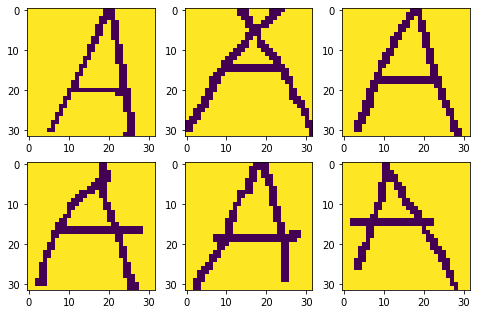

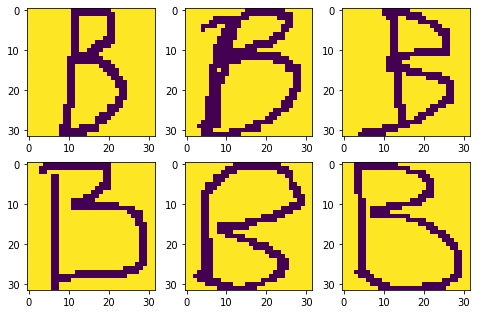

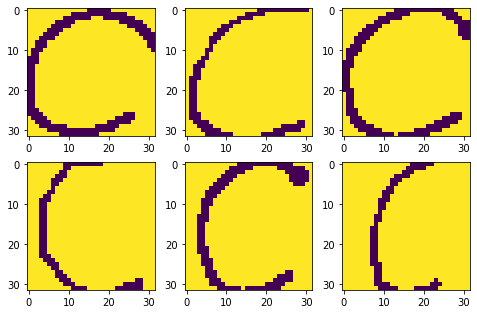

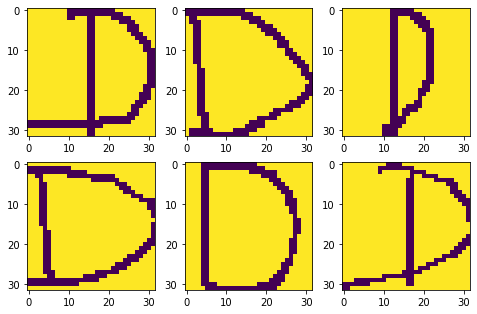

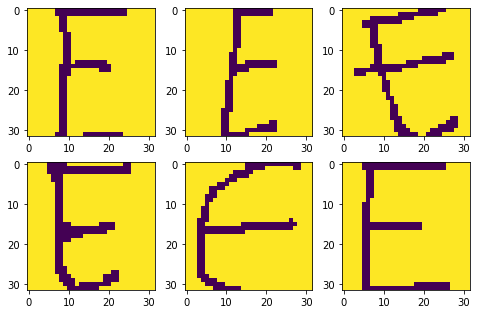

In [33]:
random_letters = list(range(5)) 
for i in random_letters:
    print(i, eng_indices[i])
    plot_6images(X['english'][eng_indices[i]])

### Here is what plotting the centroids looks like for each of these letter clusters
Centroids are essentially the average of a set of points in N-dimensional space. In this case, our images are vectors in 1024-dimensional space where each pixel is a dimension. Here, centroid A is the average of the 6 images containing letter A (same applies to the other letters).

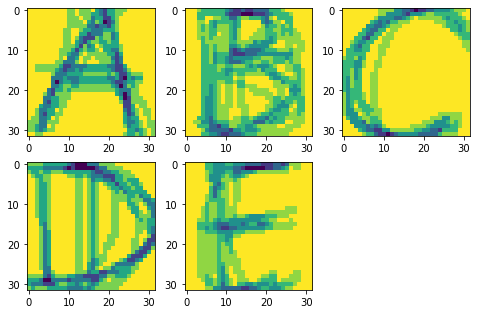

In [34]:
eng_centroids = [compute_centroid(eng_indices[i],X['english']) for i in random_letters]
plot_6images(eng_centroids)

0 [1, 18, 19, 30, 36, 37]
1 [9, 10, 14, 15, 17, 29]
2 [49, 57, 88, 94, 201, 259]
3 [7, 27, 59, 75, 87, 100]
4 [3, 8, 25, 28, 38, 42]


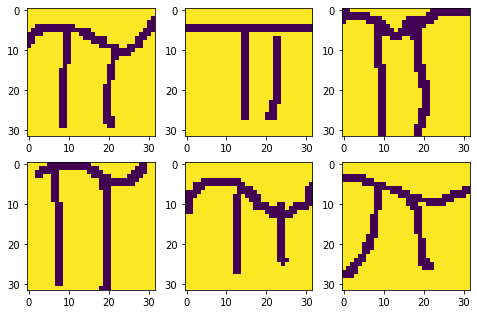

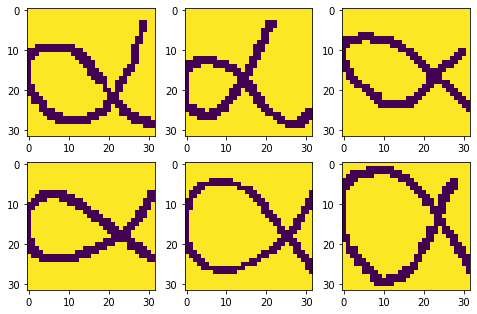

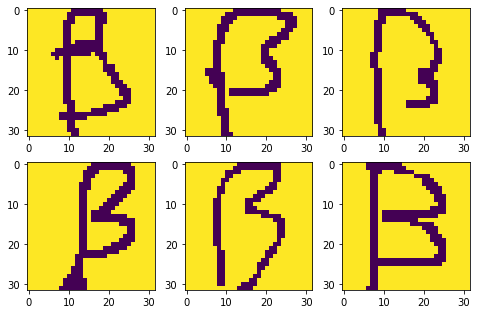

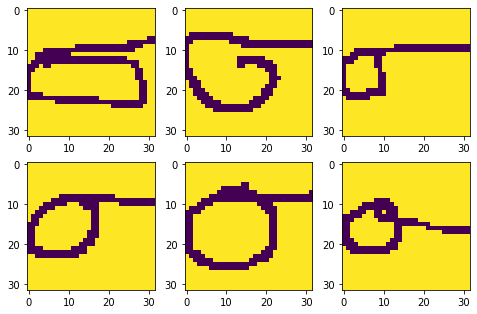

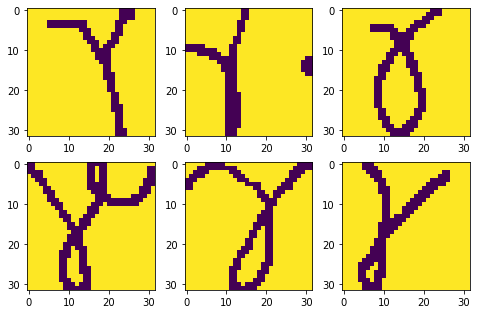

In [35]:
for i in random_letters:
    print(i, greek_indices[i])
    plot_6images(X['greek'][greek_indices[i]])

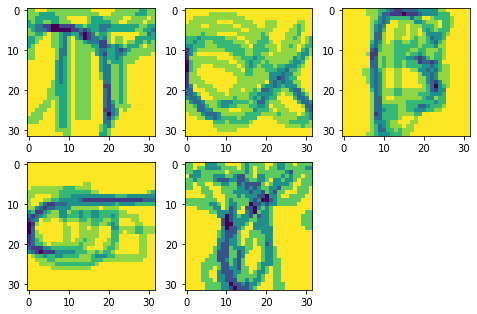

In [36]:
greek_centroids = [compute_centroid(greek_indices[i],X['greek']) for i in random_letters]
plot_6images(greek_centroids)

# Now, let's run some clustering and see what happens!!!

### First version: initialise the centroids by setting the them to distinct letters of the alphabet.
i.e, if we are using the english alphabet, there will be 26 centroids each of them will be a distinct letter. 


In [37]:
def run1(indices,X,):
    centroids = X[[i[0] for i in indices]]
    print(centroids.shape)
    assert centroids.shape == (26,1024 ) or (10,1024), f'centroids are of wrong shape {centroids.shape}'
    clusters = KMeans(n_clusters=centroids.shape[0], init=centroids, verbose=1).fit(X)
    return clusters

In [38]:
eng_clusters = run1(eng_indices, X['english'], )

(26, 1024)
Initialization complete
Iteration 0, inertia 249343.0
Iteration 1, inertia 155266.67806240116
Iteration 2, inertia 150815.0794252881
Iteration 3, inertia 148491.1685745574
Iteration 4, inertia 147120.07916926732
Iteration 5, inertia 146410.33200911034
Iteration 6, inertia 146029.29394453226
Iteration 7, inertia 145756.38084585607
Iteration 8, inertia 145573.5864446176
Iteration 9, inertia 145442.18388228377
Iteration 10, inertia 145410.06118434572
Iteration 11, inertia 145367.99376651543
Iteration 12, inertia 145352.0064486109
Iteration 13, inertia 145333.78768300632
Iteration 14, inertia 145321.83115524397
Iteration 15, inertia 145316.6758870343
Converged at iteration 15: strict convergence.


### Plotting the centroids after having clustered the whole dataset

For each letter, on the left you will find the average of all the images containing letters that where closest (in the sense of euclidean distance) to the original letter centroid shown on the right. If the image on the left is easily recognizable and similar enough to the letter on the right this is a good sign. It means that lot's of images that were deemed close turned out to be of the actual letter type of the centroid.


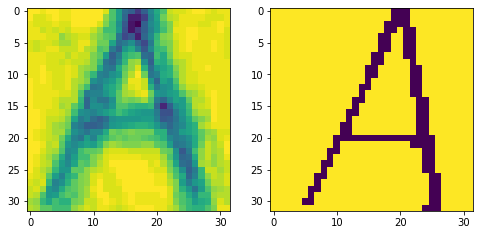

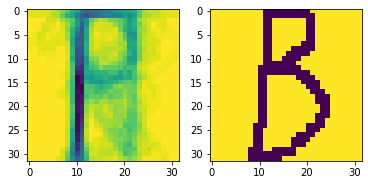

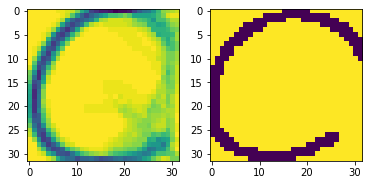

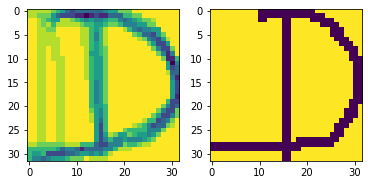

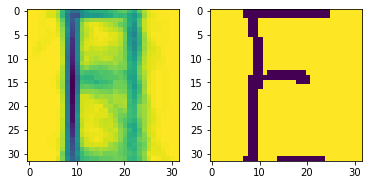

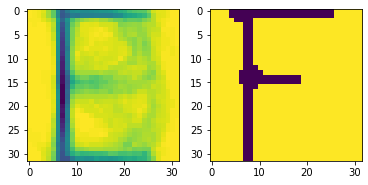

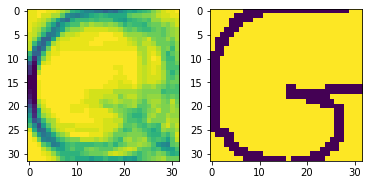

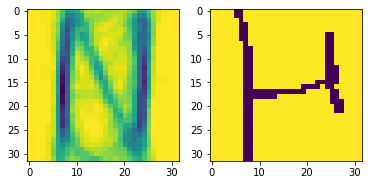

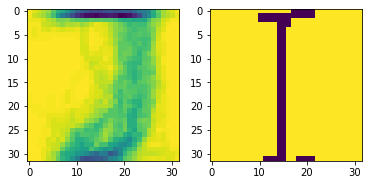

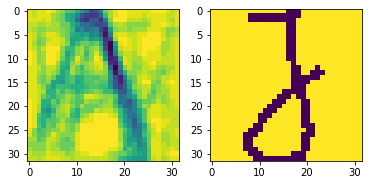

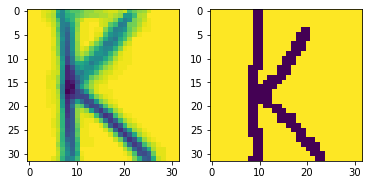

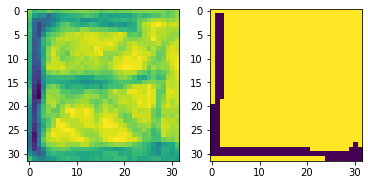

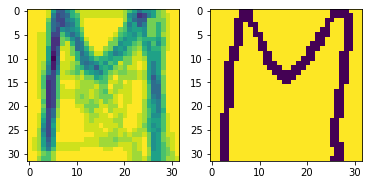

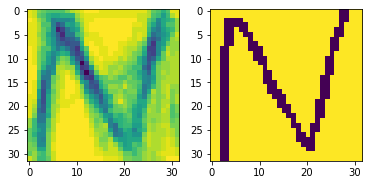

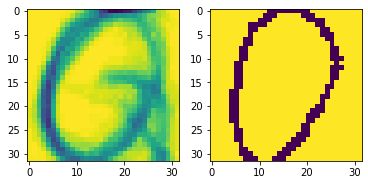

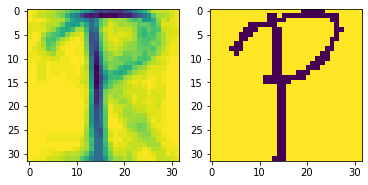

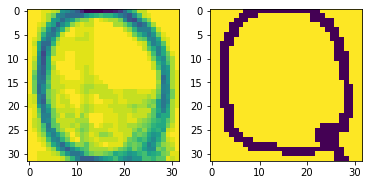

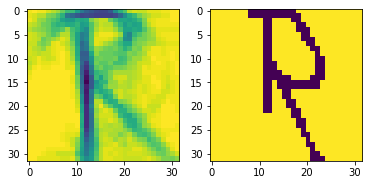

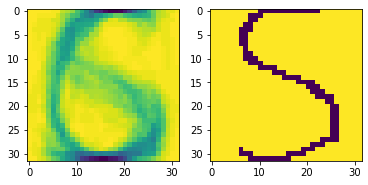

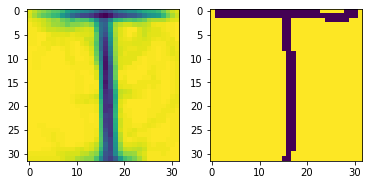

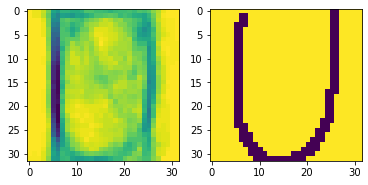

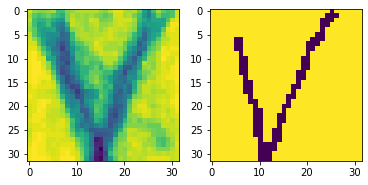

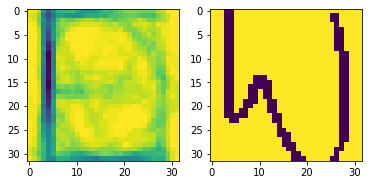

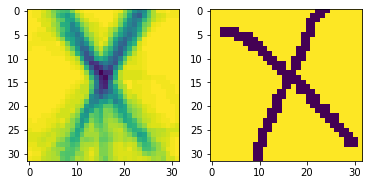

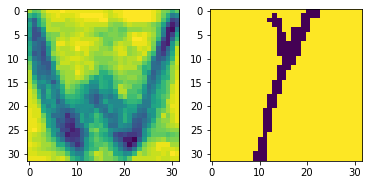

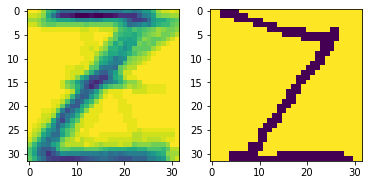

'These are the plotted centroids of after clustering the whole dataset vs the inital centroids'

In [39]:

plt.figure(figsize=(32/4,32/4))
for i,final in enumerate(eng_clusters.cluster_centers_):
    plt.subplot(1,2,1)
    plt.imshow(final.reshape(32,32),)
    plt.subplot(1,2,2)
    initial = X['english'][eng_indices[i][0]]
    plt.imshow(initial.reshape(32,32))
    plt.show()
    


### Let's see how close the clusters are to the original label classes

In [40]:

acc = sklearn.metrics.accuracy_score(y['english'],eng_clusters.labels_)
f1 = sklearn.metrics.f1_score(y['english'],eng_clusters.labels_, average='weighted')
fmt = lambda some_float: float("{:.4f}".format(some_float))

print(f'accuracy: {fmt(acc)}, f1: {fmt(f1)}')

accuracy: 0.2942, f1: 0.2956


In [41]:
def generate_stats(clusters,y_true,letter=0):
    '''for a given letter (value either [0,25] or [A,Z]), generate stats on that cluster'''
    letter = letter.upper() if type(letter)==str else letter
    lang = 'english' if len(clusters.cluster_centers_) == 26 else 'greek'
    index = letter if type(letter)==int else files[lang]['letters'].index(letter)
    # all indices in X of points associated to cluster index 0
    point_indices = np.where(clusters.labels_==index)[0] # because where returns a tuple 

    # get the real class labels of all points that were clustered together    
    real_classes = y_true[point_indices].astype(np.int)
    class_counts = Counter(real_classes)

    def indexToLetter(counterObj):
        dictt = {}
        for k,v in counterObj.items():
            letterKey = files[lang]['letters'][k]
            dictt[letterKey] = v
        
        return {k: v for k,v in sorted(dictt.items(),key=lambda el: el[0])}

    class_counts_letters = indexToLetter(class_counts)


    result = {  'letter': files[lang]['letters'][index],
                'index': index,
                'cluster_size': len(point_indices),
                'count': class_counts_letters,
            }

    return result

In [42]:
def generate_stats_plot(output_of_generate_stats_func):
    '''Self explanatory IMHO'''

    result = output_of_generate_stats_func
    plt.title(f'Cluster composition of letter {result["letter"]}')
    plt.bar(list(result['count'].keys()), list(result['count'].values()),width=0.9,color='purple')
    plt.xlabel('letters')
    plt.ylabel('occurences in this cluster')
    plt.show()


{'letter': 'A', 'index': 0, 'cluster_size': 50, 'count': {'A': 38, 'G': 1, 'H': 1, 'M': 3, 'N': 1, 'T': 1, 'W': 1, 'X': 3, 'Y': 1}}


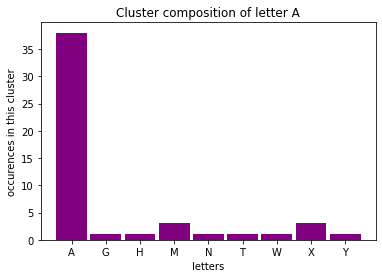


{'letter': 'B', 'index': 1, 'cluster_size': 48, 'count': {'A': 1, 'B': 5, 'E': 2, 'F': 7, 'H': 9, 'K': 1, 'L': 1, 'N': 4, 'P': 7, 'R': 10, 'T': 1}}


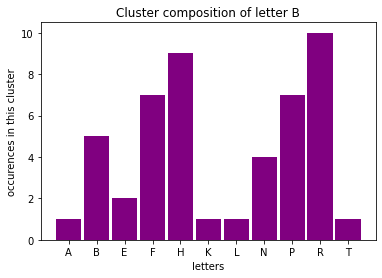


{'letter': 'C', 'index': 2, 'cluster_size': 35, 'count': {'C': 20, 'G': 2, 'O': 7, 'Q': 6}}


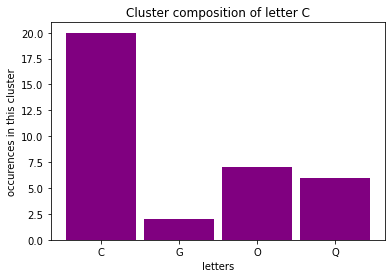


{'letter': 'W', 'index': 22, 'cluster_size': 41, 'count': {'B': 2, 'C': 5, 'D': 3, 'E': 7, 'F': 3, 'L': 10, 'M': 3, 'O': 1, 'P': 1, 'S': 1, 'U': 3, 'W': 2}}


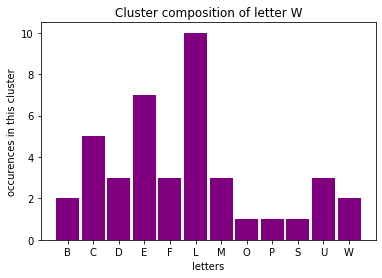


{'letter': 'Y', 'index': 24, 'cluster_size': 71, 'count': {'C': 1, 'G': 1, 'H': 2, 'K': 1, 'Q': 4, 'S': 2, 'U': 7, 'V': 5, 'W': 43, 'Z': 5}}


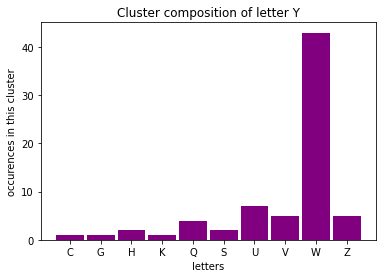


{'letter': 'Z', 'index': 25, 'cluster_size': 34, 'count': {'X': 1, 'Z': 33}}


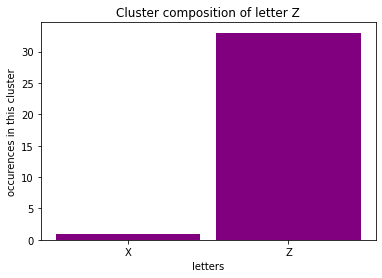

In [43]:
for l in ['A','B','C','W','Y','Z']:
    stats = generate_stats(eng_clusters,y['english'],letter=l)
    print()
    print(stats)
    
    generate_stats_plot(stats)
    

In [45]:
greek_clusters = run1(greek_indices,X['greek'])

(10, 1024)
Initialization complete
Iteration 0, inertia 2102353.0
Iteration 1, inertia 1193113.1743712134
Iteration 2, inertia 1173939.2144648926
Iteration 3, inertia 1165740.1114689887
Iteration 4, inertia 1162496.670162165
Iteration 5, inertia 1161013.440488342
Iteration 6, inertia 1160147.2311575157
Iteration 7, inertia 1159471.4612499767
Iteration 8, inertia 1158877.172074132
Iteration 9, inertia 1158235.7362366528
Iteration 10, inertia 1157736.1997715735
Iteration 11, inertia 1157402.2422157766
Iteration 12, inertia 1157146.5331490745
Iteration 13, inertia 1156934.6637649115
Iteration 14, inertia 1156669.1392739634
Iteration 15, inertia 1156323.725660704
Iteration 16, inertia 1155975.2755666913
Iteration 17, inertia 1155703.7928008437
Iteration 18, inertia 1155536.6059791571
Iteration 19, inertia 1155450.247797142
Iteration 20, inertia 1155394.7671194307
Iteration 21, inertia 1155346.8036427845
Iteration 22, inertia 1155319.1945023187
Iteration 23, inertia 1155298.7223901537
Itera

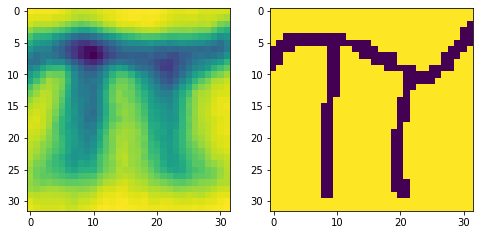

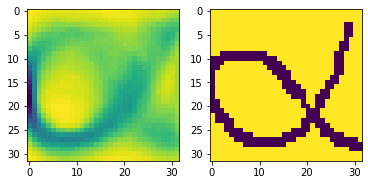

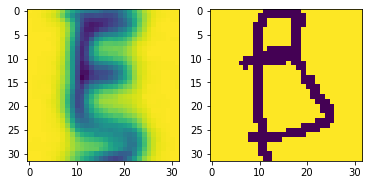

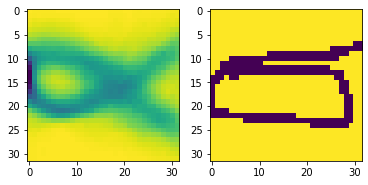

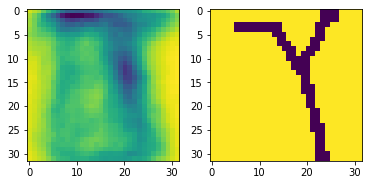

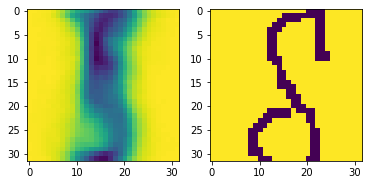

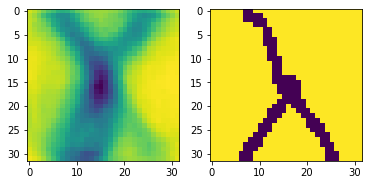

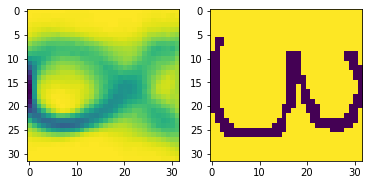

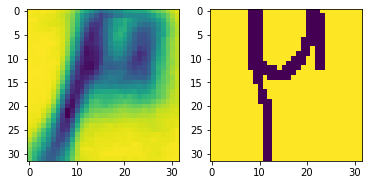

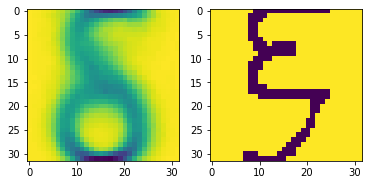

In [46]:
plt.figure(figsize=(32/4,32/4))
for i,final in enumerate(greek_clusters.cluster_centers_):
    plt.subplot(1,2,1)
    plt.imshow(final.reshape(32,32),)
    plt.subplot(1,2,2)
    initial = X['greek'][greek_indices[i][0]]
    plt.imshow(initial.reshape(32,32))
    plt.show()

In [47]:
acc = sklearn.metrics.accuracy_score(y['greek'],greek_clusters.labels_)
f1 = sklearn.metrics.f1_score(y['greek'],greek_clusters.labels_, average='weighted')
fmt = lambda some_float: float("{:.4f}".format(some_float))

print(f'accuracy: {fmt(acc)}, f1: {fmt(f1)}')

accuracy: 0.2796, f1: 0.3



{'letter': 'π', 'index': 0, 'cluster_size': 966, 'count': {'µ': 144, 'α': 44, 'β': 7, 'γ': 54, 'δ': 1, 'λ': 4, 'ξ': 20, 'π': 662, 'σ': 28, 'ω': 2}}


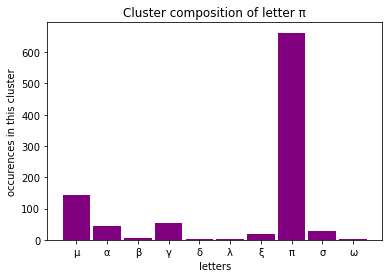


{'letter': 'α', 'index': 1, 'cluster_size': 886, 'count': {'µ': 4, 'α': 643, 'β': 3, 'γ': 6, 'δ': 7, 'ξ': 4, 'π': 2, 'σ': 111, 'ω': 106}}


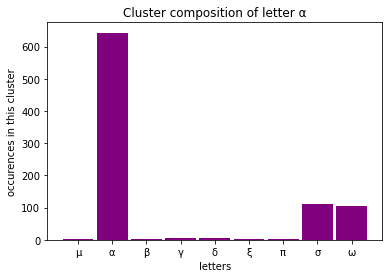


{'letter': 'β', 'index': 2, 'cluster_size': 1058, 'count': {'µ': 45, 'β': 39, 'γ': 21, 'δ': 28, 'ξ': 916, 'π': 9}}


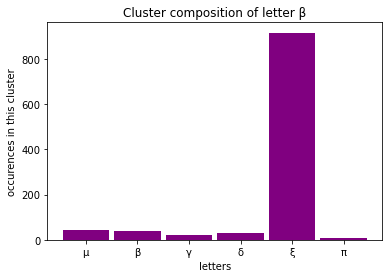


{'letter': 'σ', 'index': 3, 'cluster_size': 1025, 'count': {'µ': 27, 'α': 835, 'β': 1, 'γ': 3, 'δ': 1, 'λ': 2, 'ξ': 4, 'π': 64, 'σ': 38, 'ω': 50}}


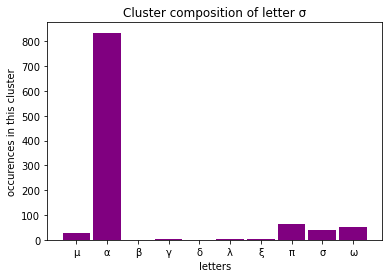


{'letter': 'γ', 'index': 4, 'cluster_size': 955, 'count': {'µ': 44, 'α': 58, 'β': 73, 'γ': 156, 'δ': 93, 'λ': 78, 'ξ': 182, 'π': 241, 'σ': 28, 'ω': 2}}


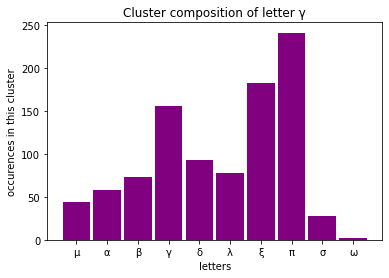

In [48]:
for l in range(5):
    stats = generate_stats(greek_clusters,y['greek'],letter=l)
    print()
    print(stats)
    generate_stats_plot(stats)

## Interpretation:

It is interesting to see how attempting to classify the alphabet without having the image labels is a much harder problem resulting in roughly ~30% accuracy for the english and greek alphabet.

That said, you can predict which letters were clustered relatively well by looking above at the images of the final centroids next to the original letter they were supposed to predict.

For some of them, you can clearly recognize the initial letter that the centroid is supposed to predict (for e.g A, and π which are pretty clear after clustering). For other letters, the distortion is such that you could not tell the original letter of the cluster that they are trying to predict. Cross reference this with the bar charts showing which letters ended up in which clusters and you can see where the algorithm went wrong. 

What determines which letters get clustered well and which don't? The first and most intuitive hypthesis thought of is that some letters are inherently more unique in their representation, which makes it easier for the algorithm to tell them apart (remember that telling letters appart involves comparing them by euclidean distance). On the other hand, our datasets aren't perfect and there are some letters that are under-represented in the datasets, therefore dragging along with them the problems of class imbalance. You can cross reference the results in this experiment with the [notebook on data exploration](https://github.com/mohanadarafe/comp472-a1/blob/main/data_exploration.ipynb) which takes a look at these problems.

## Try it yourself below.


{'letter': 'R', 'index': 17, 'cluster_size': 50, 'count': {'A': 1, 'B': 3, 'D': 5, 'F': 1, 'H': 4, 'P': 5, 'R': 22, 'S': 1, 'T': 5, 'V': 1, 'Y': 2}}


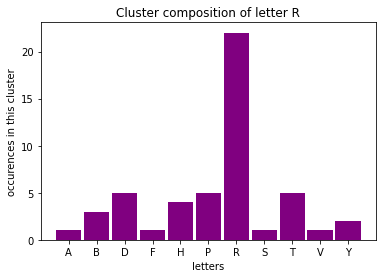

In [51]:
'''Just change the value of the <letter> argument to any english letter of your choice'''



ENGLISH_LETTER = "R"    # <- write you letter in between the quotes here



stats = generate_stats(eng_clusters,y['english'],letter=ENGLISH_LETTER)
print()
print(stats)
generate_stats_plot(stats)


{'letter': 'ω', 'index': 7, 'cluster_size': 899, 'count': {'µ': 5, 'α': 701, 'β': 1, 'δ': 1, 'π': 3, 'σ': 70, 'ω': 118}}


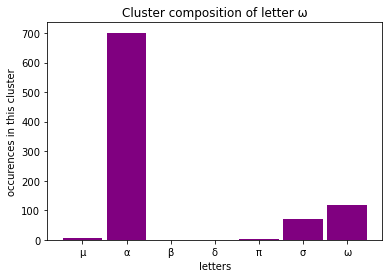

In [56]:
'''Just change the value of the <letter> argument to any number between [0-9] of your choice'''



NUMBER = 7    # <- write you number (representing a greek letter) here



stats = generate_stats(greek_clusters,y['greek'],letter=NUMBER)
print()
print(stats)
generate_stats_plot(stats)